In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.style.use("seaborn")
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data = pd.read_csv("./datasets/Metro_time_series.csv")

In [3]:
cols = ['Date', 'RegionName', 'ZHVI_AllHomes']
data = data[data['ZHVI_AllHomes'] > 0]
data = data.filter(cols)
data = data.rename(columns={"RegionName": "CBSA_Code"})
cityList = np.unique(data['CBSA_Code'])
metro = []
for code in tqdm(cityList):
    metro.append(data[data['CBSA_Code']  == str(code)])
metro

100%|██████████| 730/730 [00:05<00:00, 129.59it/s]


[              Date CBSA_Code  ZHVI_AllHomes
 15439   1998-02-28     10140        80100.0
 16171   1998-03-31     10140        81100.0
 16903   1998-04-30     10140        83000.0
 17637   1998-05-31     10140        84500.0
 18371   1998-06-30     10140        85500.0
 ...            ...       ...            ...
 206628  2017-08-31     10140       147100.0
 207539  2017-09-30     10140       148800.0
 208450  2017-10-31     10140       150000.0
 209361  2017-11-30     10140       151400.0
 210272  2017-12-31     10140       153000.0
 
 [239 rows x 3 columns],               Date CBSA_Code  ZHVI_AllHomes
 1       1996-04-30     10220        28600.0
 685     1996-05-31     10220        28900.0
 1372    1996-06-30     10220        29100.0
 2060    1996-07-31     10220        29500.0
 2749    1996-08-31     10220        30300.0
 ...            ...       ...            ...
 206630  2017-08-31     10220       103800.0
 207541  2017-09-30     10220       104700.0
 208452  2017-10-31     10220

In [6]:
def movingAverage_normalize(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n
    return np.array([(x-np.mean(moving_avg))/np.std(moving_avg) for x in moving_avg])
#fig, ax = plt.subplots()
#ax.scatter(pd.to_datetime(city1['Date'][4:]).dt.date, movingAverage_normalize(city1['ZHVI_AllHomes'].values))
#plt.show()
movingAverage_normalize(city1['ZHVI_AllHomes'].values)
# don't send moving average 
#  CHECK IF AFFECTS MOVING AVERAGE AFFECTS ARIMA

array([-1.52245317, -1.46376916, -1.41346858, -1.37993486, -1.36526386,
       -1.36631179, -1.37155143, -1.38517451, -1.41137273, -1.43547509,
       -1.44805023, -1.45957745, -1.46796088, -1.47424845, -1.48891945,
       -1.51826146, -1.55179518, -1.58847268, -1.61991055, -1.64610876,
       -1.67021113, -1.69221763, -1.70374485, -1.70164899, -1.68278627,
       -1.64925255, -1.60628747, -1.55913068, -1.51721353, -1.48787152,
       -1.46796088, -1.4470023 , -1.41870823, -1.37783901, -1.31810707,
       -1.24684791, -1.17768462, -1.11690475, -1.07079589, -1.03621424,
       -0.99744087, -0.94714029, -0.88950421, -0.8308202 , -0.78575927,
       -0.75956105, -0.74803383, -0.75012969, -0.76480069, -0.78156755,
       -0.78890305, -0.78995098, -0.79309477, -0.79099891, -0.78261548,
       -0.78156755, -0.78051962, -0.77108826, -0.76270484, -0.76165691,
       -0.76794448, -0.78051962, -0.79309477, -0.8088137 , -0.82138884,
       -0.8234847 , -0.82767642, -0.84549121, -0.86854564, -0.89

              Date CBSA_Code  ZHVI_AllHomes
48      1996-04-30     13020        65200.0
732     1996-05-31     13020        65400.0
1419    1996-06-30     13020        65900.0
2107    1996-07-31     13020        66300.0
2796    1996-08-31     13020        66700.0
...            ...       ...            ...
206695  2017-08-31     13020        89200.0
207606  2017-09-30     13020        89100.0
208517  2017-10-31     13020        89900.0
209428  2017-11-30     13020        90800.0
210339  2017-12-31     13020        91600.0

[261 rows x 3 columns]


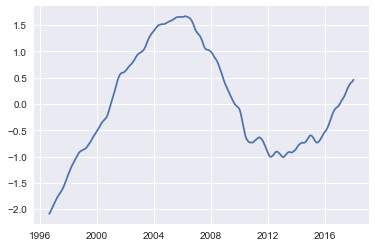

In [7]:
city1 = metro[0]
ames = data[data.CBSA_Code == '13020']
print(ames)
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(ames['Date'][4:]).dt.date, movingAverage_normalize(ames['ZHVI_AllHomes'].values))
# ax.scatter(pd.to_datetime('2009-05-31'), ames[ames['Date'] == '2009-05-31']['ZHVI_AllHomes'])

In [8]:
THRESHOLD = 1

# def find_max_start(city):
#     return type == str

def find_start(city):
    """
    returns recession start date, measured as the largest local maximum ZHVI for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm]
    returns: start_date (pd.datetime)
    """
    last_date = city.sort_values('Date', ascending=False).iloc[0]['Date']
    city = city[city['Date'] < '2015']
    d = lambda i: city['ZHVI_AllHomes'].iloc[i] - city['ZHVI_AllHomes'].iloc[i-1]
    diffs = np.array([d(i) for i in range(1, len(city))])
    # reshape dataframe to include diffs
    city = city.iloc[1:]
    city['Diffs'] = diffs
    # find local maxes using diffs
    is_max = np.array([(city['Diffs'].iloc[i] >= 0) 
                       and (city['Diffs'].iloc[i+1] <= 0) 
                       and (city['Diffs'].iloc[i+1] - city['Diffs'].iloc[i] <= THRESHOLD) for i in range(len(city) - 1)])
    is_max = np.append(is_max, False)

    # check for presence of local maxes at all
    if np.count_nonzero(is_max) == 0:
        return last_date
    # add 'is_maximum' truth column to dataframe
    city['Max'] = is_max
    # filter and find largest max
    theMax = city[city['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
    start_date = theMax['Date']
    return start_date

In [9]:
failed_cities = []
def ARIMA_50(city, start, params=(5,1,1)):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    start -- datetime object from index of city representing peak ZHVI
    params -- p, d, and q parameters for ARIMA
    """
    
    #add start.dt.strftime('%Y-%m-%d') to convert datetime to string
    
    from statsmodels.tsa.arima_model import ARIMA
    
    before = city[['Date', 'ZHVI_AllHomes']]
#     print(before.shape, start)
    before = before[before['Date'] < start].set_index(['Date'])['ZHVI_AllHomes'].values
    steps = city.shape[0] - before.shape[0]
    try:
        model = ARIMA(before, order=(5, 1, 1))
        model_fit = model.fit(disp=0)
        return model_fit.forecast(steps)[0]
    except:
        failed_cities.append(np.unique(city.CBSA_Code)[0])
        return np.repeat(city[city['Date'] == start].ZHVI_AllHomes, steps)

In [10]:
def find_end(city, start, ARIMA_50):
    """
    returns recession end date, measured as the first point of intersection between ZHVI and ARIMA_50 for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm], ARIMA_50 (pd.dataframe) [Date, forecasted_ZHVI_norm] 
    returns: end_date (pd.datetime)
    """
    # calculate diffs
    recession_ZHVI = city[city['Date'] >= start]
    diffs = ARIMA_50 - recession_ZHVI['ZHVI_AllHomes'].values
    city_resid = pd.DataFrame(data={'Date': recession_ZHVI['Date'].values, 'Delta': diffs})
    # filter only positive residuals, and most recent one is the last recession date
    most_recent_positive_delta = city_resid[city_resid['Delta'] > 0].sort_values("Date", ascending=False)
   # if ARIMA model indicates a sharp drop, set end date as one month after start date
    if (most_recent_positive_delta.shape[0] == 0):
        return city_resid.Date.values[0]
    end_date = most_recent_positive_delta['Date'].iloc[0]
#     print(end_date)
    return end_date

In [11]:
def calc_resid(city, predicted, start, end):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    predicted -- predicted values from max to last date of city time-series
    max -- datetime object from index of city representing peak ZHVI
    end -- datetime object from index of city representing intersection of 
    actual and predicted ZHVI or last date of actual
    """
    
    # get indices of start and end date and use those to splice arrays
    recession_ZHVI = city[city['Date'] >= start]
    recession_ZHVI = recession_ZHVI[recession_ZHVI['Date'] < end]
    end_index = len(recession_ZHVI)
    predicted_to_end = predicted[:end_index]
    diffs = predicted_to_end - recession_ZHVI['ZHVI_AllHomes'].values
    return sum(diffs)

In [12]:
def find_AU3(metro):
#     print("City: {}".format(np.unique(metro.CBSA_Code)))
    start = find_start(metro)
    arima = ARIMA_50(metro, start)
#     print("Start Date: ", start)
#     fig, ax = plt.subplots()
#     ax.plot(pd.to_datetime(metro['Date'][4:]).dt.date, movingAverage_normalize(metro['ZHVI_AllHomes'].values))
#     print(metro[metro['Date'] > start].shape)
    end = find_end(metro, start, arima)
#     print("End Date: ", end)
    return calc_resid(metro, arima, start, end)

In [13]:
AU3_output = list(map(find_AU3, metro))

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/regres

In [14]:
failed_cities

['11180',
 '11380',
 '11680',
 '12420',
 '13700',
 '13940',
 '14700',
 '14780',
 '15020',
 '16060',
 '16180',
 '16260',
 '17200',
 '17740',
 '18020',
 '18900',
 '19860',
 '20180',
 '20380',
 '20580',
 '21420',
 '21540',
 '21740',
 '22100',
 '24460',
 '24780',
 '25200',
 '25700',
 '26420',
 '26740',
 '26900',
 '27420',
 '27620',
 '27920',
 '28260',
 '28780',
 '29500',
 '29660',
 '30060',
 '30580',
 '31740',
 '32020',
 '32700',
 '32860',
 '34140',
 '34180',
 '35840',
 '36220',
 '36840',
 '37580',
 '39340',
 '39500',
 '40180',
 '41460',
 '41700',
 '41760',
 '43060',
 '43260',
 '43460',
 '43580',
 '43940',
 '44900',
 '44940',
 '45820',
 '46300',
 '46620',
 '46860',
 '47660',
 '48460']

(18.62794979176254, 0)

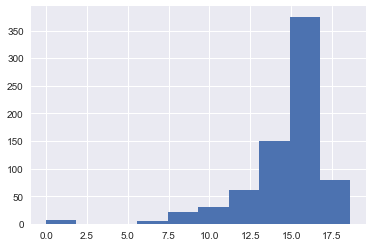

In [21]:
adjusted_outputs = [np.log(i) if i > 0 else 0 for i in np.abs(AU3_output)]
plt.hist(adjusted_outputs)
max(adjusted_outputs), min(adjusted_outputs)

In [22]:
cbsa_codes = [m['CBSA_Code'].iloc[0] for m in metro]

final_metro = pd.DataFrame(data={"CBSA_Codes": cbsa_codes, "AU3": adjusted_outputs})
final_metro.to_csv("AU3_results.csv")

In [23]:
final_metro

,CBSA_Codes,AU3
0,10140,15.501357
1,10220,10.457634
2,10300,16.036767
3,10420,15.194709
4,10500,15.203063
...,...,...
725,49700,17.146277
726,49740,16.426825
727,49780,13.888078
728,49820,8.604124


## Everything below this cell is experimental/debugging

In [ ]:
# RANDOM STUFF DELETE LATER

from statsmodels.tsa.arima_model import ARIMA
city1.tail()
before = city1[['Date', 'ZHVI_AllHomes']][city1['Date'] < '2017-08-31'].set_index(['Date'])['ZHVI_AllHomes']
model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
model_fit = model.fit(disp=0)
#np.array(before, dtype=np.float)[0]
#city1['dt'] = city1
#np.array(city1['Date'], dtype='datetime64')
model_fit.predict(before.shape[0], city1.shape[0])

In [ ]:
city1 = city1[city1['Date'] < "2012"]
d = lambda i: city1['ZHVI_AllHomes'].iloc[i] - city1['ZHVI_AllHomes'].iloc[i-1]
diffs = np.array([d(i) for i in range(1, len(city1))])
# reshape dataframe to include diffs
city1 = city1.iloc[1:]
city1['Diffs'] = diffs
city1['Diffs']
# find local maxes using diffs
is_max = np.array([(city1['Diffs'].iloc[i] >= 0) and (city1['Diffs'].iloc[i+1] <= 0) for i in range(len(city1) - 1)])
is_max = np.append(is_max, False)

# check for presence of local maxes at all
if np.count_nonzero(is_max) == 0:
    print(0)
# add 'is_maximum' truth column to dataframe
city1['Max'] = is_max
# filter and find largest max
theMax = city1[city1['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
start_date = theMax['Date']
start_date